In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path().absolute().parent))
import time

In [2]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
import torch
from torch.nn import MSELoss
from torch.optim import Adam
import matplotlib.pyplot as plt
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pandas as pd
import glob
from pathlib import Path

from src.data_models.camels_ch import CamelsCH, CamelsCHConfig, get_all_gauge_ids
from src.data_models.dataset import HydroDataset
from src.data_models.preprocessing import (
    scale_time_series,
    scale_static_attributes,
    inverse_scale_static_attributes,
    inverse_scale_time_series,
)
from src.data_models.caravanify import Caravanify, CaravanifyConfig 

from utils.metrics import nash_sutcliffe_efficiency
from src.data_models.datamodule import HydroDataModule

---

## Testing Caravanify

In [3]:
config = CaravanifyConfig(
    attributes_dir="/Users/cooper/Desktop/CAMELS-CH/data/CARAVANIFY/CH/post_processed/attributes",
    timeseries_dir="/Users/cooper/Desktop/CAMELS-CH/data/CARAVANIFY/CH/post_processed/timeseries/csv",
    gauge_id_prefix="CH",
    use_hydroatlas_attributes=True,
    use_caravan_attributes=True,
    use_other_attributes=True,
)


caravan = Caravanify(config)
ids_for_training = [
    "CH_4011",
    "CH_5009",
]
# ids_for_training = caravan.get_all_gauge_ids()[:3]

print(f"Total number of stations: {len(ids_for_training)}")

caravan.load_stations(ids_for_training)


# Get data
ts_data = caravan.get_time_series()  # MultiIndex: (gauge_id, date)
static_data = caravan.get_static_attributes()  # Columns merged from enabled attributes

Total number of stations: 2


In [4]:
ts_data["date"] = pd.to_datetime(ts_data["date"])

# Now we can get the day of year using dt accessor
ts_data["julian_day"] = ts_data["date"].dt.dayofyear

# Get column names excluding specific columns
ts_columns = [
    "potential_evaporation_sum_ERA5_LAND",
    "potential_evaporation_sum_FAO_PENMAN_MONTEITH",
    "streamflow",
    "julian_day",
    "temperature_2m_mean",
    "total_precipitation_sum",
]

In [5]:
ts_data

,gauge_id,date,snow_depth_water_equivalent_mean,surface_net_solar_radiation_mean,surface_net_thermal_radiation_mean,surface_pressure_mean,temperature_2m_mean,dewpoint_temperature_2m_mean,u_component_of_wind_10m_mean,v_component_of_wind_10m_mean,...,v_component_of_wind_10m_max,volumetric_soil_water_layer_1_max,volumetric_soil_water_layer_2_max,volumetric_soil_water_layer_3_max,volumetric_soil_water_layer_4_max,total_precipitation_sum,potential_evaporation_sum_ERA5_LAND,potential_evaporation_sum_FAO_PENMAN_MONTEITH,streamflow,julian_day
0,CH_4011,1981-01-02,17.08,11.40,-18.39,95.45,-0.09,-1.70,4.43,2.46,...,3.68,0.39,0.38,0.41,0.40,12.37,1.00,0.22,NaN,2
1,CH_4011,1981-01-03,20.27,9.10,-9.54,94.27,3.10,1.00,6.67,3.91,...,4.61,0.43,0.43,0.41,0.40,15.01,1.93,0.52,NaN,3
2,CH_4011,1981-01-04,15.83,10.61,-26.93,93.69,1.17,0.12,3.75,0.98,...,1.86,0.43,0.43,0.42,0.40,15.42,0.52,0.01,NaN,4
3,CH_4011,1981-01-05,20.68,26.82,-49.44,94.72,-2.20,-5.34,4.79,-1.08,...,0.60,0.41,0.42,0.42,0.40,3.26,1.87,0.30,NaN,5
4,CH_4011,1981-01-06,26.47,14.47,-29.60,94.50,-2.32,-4.35,3.35,-0.06,...,3.24,0.40,0.41,0.42,0.40,9.59,1.09,0.11,NaN,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29213,CH_5009,2020-12-27,12.76,23.51,-25.11,89.06,-0.94,-6.32,1.30,3.73,...,6.20,0.39,0.39,0.42,0.42,5.22,3.26,0.67,NaN,362
29214,CH_5009,2020-12-28,21.16,35.30,-39.44,87.30,-0.05,-2.43,1.87,3.81,...,5.09,0.40,0.38,0.42,0.42,13.42,1.79,0.32,NaN,363
29215,CH_5009,2020-12-29,33.75,31.13,-34.64,88.26,-0.83,-2.38,2.01,2.79,...,4.35,0.39,0.38,0.42,0.42,12.54,0.91,0.17,NaN,364
29216,CH_5009,2020-12-30,40.55,24.43,-30.62,89.30,-2.82,-4.07,1.07,1.04,...,1.80,0.38,0.38,0.41,0.42,4.02,0.24,0.01,NaN,365


In [6]:
whole_data = ts_columns + ["gauge_id", "date"]
ts_data = ts_data[whole_data]

# # Group by gauge_id 
# grouped = ts_data.groupby("gauge_id")

# # Plot time series for each gauge of the ts_columns of the last 5 years
# for gauge_id, group in grouped:
#     group = group.set_index("date")
#     group = group.loc["2015-01-01":"2020-12-31"]
#     group[ts_columns].plot(subplots=True, figsize=(20, 20), title=gauge_id)
#     plt.show()



In [7]:
statics_to_keep = [
    "gauge_id",
    "p_mean",
    "area",
    "ele_mt_sav",
    "high_prec_dur",
    "frac_snow",
    "high_prec_freq",
    "slp_dg_sav",
    "cly_pc_sav",
    "aridity_ERA5_LAND",
    "aridity_FAO_PM",
]

static_columns = static_data.columns
static_columns = [col for col in list(static_columns) if col in statics_to_keep]

static_data = static_data[static_columns]
static_data

,gauge_id,area,cly_pc_sav,ele_mt_sav,slp_dg_sav,aridity_ERA5_LAND,aridity_FAO_PM,frac_snow,high_prec_dur,high_prec_freq,p_mean
0,CH_4011,190.019704,17.986799,560.920078,42.453751,0.979546,0.492789,0.065489,1.153477,0.032925,3.191584
1,CH_5009,141.339042,20.967316,1104.135496,66.945681,0.686178,0.346108,0.154859,1.121519,0.030324,4.981448


# 1. Load and prepare CAMELS-CH data

In [8]:
# camels_config = CamelsCHConfig(
#     timeseries_dir="/Users/cooper/Desktop/CAMELS-CH/data/timeseries/observation_based/",
#     timeseries_pattern="CAMELS_CH_obs_based_*.csv",
#     static_attributes_dir="/Users/cooper/Desktop/CAMELS-CH/data/static_attributes",
#     use_climate=False,
#     use_geology=False,
#     use_glacier=False,
#     use_human_influence=False,
#     use_hydrogeology=False,
#     use_hydrology=False,
#     use_landcover=False,
#     use_soil=False,
#     use_topographic=False,
# )

In [9]:
# all_gauge_ids = get_all_gauge_ids(camels_config)

# ids_for_training = all_gauge_ids[:5]

# camels = CamelsCH(camels_config)
# camels.load_stations(ids_for_training)

In [10]:
# data = camels.get_time_series()
# data = data[
#     [
#         "gauge_id",
#         "date",
#         "discharge_spec(mm/d)",
#     ]
# ]

# data

In [11]:
# static = camels.get_static_attributes()
# sc = static.columns

# # for i in range(len(sc)):
# #     print(f"{i}: {sc[i]}")
# static_attributes = [
#     "gauge_id",
#     "area", 
#     "elev_mean",  
#     "slope_mean",  
#     "aridity",  
#     "p_seasonality",  
#     "frac_snow",  
#     "porosity",  
#     "conductivity",  
#     "p_mean",  
#     "geo_porosity",  
# ]
# static = static[static_attributes]
# static

# 2. Configure preprocessing

In [12]:
preprocessing_config = {
    "features": {
        "scale_method": "per_basin",
        "log_transform": []
    },
    "target": {
        "scale_method": "per_basin",
        "log_transform": False
    },
    "static_features": {
        "scale_method": "global"
    }
}

# 3. Create DataModule

In [14]:
output_length = 10


data_module = HydroDataModule(
    time_series_df=ts_data,
    static_df=static_data,
    group_identifier="gauge_id",
    preprocessing_config=preprocessing_config,
    batch_size=32,
    input_length=30,
    output_length=output_length,
    num_workers=4,
    features=ts_columns,
    static_features=static_columns,
    target="streamflow",
    min_train_years=15,
    val_years=5,
    test_years=5,
)

data_module.prepare_data()  # Process the data
data_module.setup()  # Create train/val/test splits

# Now check the processing
print("Static features:", data_module.static_features)
print("Static data processed:", data_module.processed_static is not None)
print("Static scalers present:", "static" in data_module.scalers)

/Users/cooper/Desktop/CAMELS-CH/src/data_models/preprocessing.py:128: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 1.164  1.174  1.183 ... -0.485 -0.475 -0.466]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  df_scaled.loc[mask, feat] = np.round(scaled_values, decimals=3)


Created 19242 valid sequences
Created 3574 valid sequences
Created 3531 valid sequences

Data split summary:
Training: 19365 samples from 2 basins
Validation: 3652 samples from 2 basins
Testing: 3654 samples from 2 basins
Static features: ['gauge_id', 'area', 'cly_pc_sav', 'ele_mt_sav', 'slp_dg_sav', 'aridity_ERA5_LAND', 'aridity_FAO_PM', 'frac_snow', 'high_prec_dur', 'high_prec_freq', 'p_mean']
Static data processed: True
Static scalers present: True


In [15]:
data_module.target

'streamflow'

## 4. Create model and train

In [16]:
from src.models.lstm import LitLSTM
from src.models.ealstm import LitEALSTM
from src.models.TSMixer import LitTSMixer
from src.models.evaluators import TSForecastEvaluator
from torch.optim import Adam
from torch.nn import MSELoss

# 5. Evalue and plot results

In [17]:
# model = LitLSTM(
#     input_size=len(ts_columns),
#     hidden_size=16,
#     num_layers=1,
#     output_size=output_length,
#     target=data_module.target,
# )

# model = LitEALSTM(
#     input_size_dyn=len(ts_columns),
#     input_size_stat=len(static_columns) - 1,
#     hidden_size=64,
#     output_size=output_length,
#     target=data_module.target,
# )

model = LitTSMixer(
    input_len=30,
    output_len=output_length,
    input_size=len(ts_columns),
    static_size=len(static_columns) - 1,
    hidden_size=64,
)

# Configure trainer
trainer = pl.Trainer(
    max_epochs=1,
    accelerator="cpu",
    devices=1,
    callbacks=[
        ModelCheckpoint(
            monitor="val_loss",
            dirpath="checkpoints",
            filename="best-checkpoint",
            save_top_k=1,
            mode="min",
        ),
        EarlyStopping(monitor="val_loss", patience=3, mode="min"),
    ],
)

# Train the model
trainer.fit(model, data_module)

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/cooper/Desktop/CAMELS-CH/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/cooper/Desktop/CAMELS-CH/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default
/Users/cooper/Desktop/CAMELS-CH/src/data_models/preprocessing.py:128: FutureWarning: Setting an item of incompatible dtype is deprecated and wil

Created 19242 valid sequences
Created 3574 valid sequences

Data split summary:
Training: 19365 samples from 2 basins
Validation: 3652 samples from 2 basins
Testing: 3654 samples from 2 basins


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.


In [18]:
quality_report = data_module.quality_report

excluded_basins = list(quality_report["excluded_basins"].keys())
excluded_basins

ids_for_training = [id for id in ids_for_training if id not in excluded_basins]

In [19]:
trainer.test(model, data_module)
raw_results = model.test_results

# Create evaluator and get metrics
evaluator = TSForecastEvaluator(
    data_module, horizons=list(range(1, model.config.pred_len + 1))
)
results_df, overall_metrics, basin_metrics = evaluator.evaluate(raw_results)

# Get overall summary
overall_summary = evaluator.summarize_metrics(overall_metrics)

# Get per-basin summary
basin_summary = evaluator.summarize_metrics(basin_metrics, per_basin=True)

Created 3531 valid sequences

Data split summary:
Training: 19365 samples from 2 basins
Validation: 3652 samples from 2 basins
Testing: 3654 samples from 2 basins


/Users/cooper/Desktop/CAMELS-CH/src/data_models/preprocessing.py:128: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 1.164  1.174  1.183 ... -0.485 -0.475 -0.466]' has dtype incompatible with int32, please explicitly cast to a compatible dtype first.
  df_scaled.loc[mask, feat] = np.round(scaled_values, decimals=3)


Testing: |          | 0/? [00:00<?, ?it/s]

In [20]:
overall_summary

,MSE,MAE,NSE,RMSE
horizon,,,,
1,1.246510,0.529535,0.764129,1.116472
2,2.536140,0.699535,0.518299,1.592526
3,3.196433,0.832426,0.388570,1.787857
4,3.556032,0.908060,0.318890,1.885744
5,3.698723,0.933635,0.291394,1.923206
6,3.893151,0.987546,0.254125,1.973107
7,4.021105,1.005292,0.229640,2.005269
8,4.093926,1.021904,0.215738,2.023345
9,4.146524,1.068925,0.205722,2.036302


In [21]:
basin_summary

MSE       MAE       NSE      RMSE
basin_id horizon                                        
CH_4011  1        0.264698  0.236728  0.674243  0.514488
         2        0.489206  0.307733  0.397815  0.699433
         3        0.588982  0.357431  0.274888  0.767451
         4        0.632429  0.374445  0.221303  0.795254
         5        0.654713  0.379223  0.193727  0.809143
         6        0.675819  0.402739  0.167490  0.822082
         7        0.694749  0.405460  0.143988  0.833516
         8        0.691546  0.408167  0.147835  0.831593
         9        0.697975  0.419523  0.139874  0.835449
         10       0.701785  0.428960  0.135176  0.837726
CH_5009  1        2.203612  0.814974  0.752243  1.484457
         2        4.531557  1.081476  0.488648  2.128745
         3        5.738261  1.295466  0.347703  2.395467
         4        6.406054  1.428245  0.271023  2.531018
         5        6.666121  1.474093  0.241440  2.581883
         6        7.029510  1.557635  0.200239  2.651322
         7        7.263745  1.590028  0.173748  2.695133
         8        7.410676  1.620194  0.157189  2.722256
         9        7.508282  1.701982  0.146227  2.740124
         10       7.612536  1.701159  0.134505  2.759083

In [22]:
print(raw_results['predictions'].isnan().any())
print(raw_results['observations'].isnan().any())

tensor(False)
tensor(False)


In [23]:
target_scalers = data_module.scalers['target']
print(target_scalers.scalers[target_scalers.feature_names[0]]) # Check fitted parameters

{'CH_4011': StandardScaler(), 'CH_5009': StandardScaler()}


In [24]:
test_indices = data_module.test_dataset.index
print(test_indices[test_indices['gauge_id'].isin(['CH_4011', 'CH_5009'])])

     gauge_id  start_idx
0     CH_4011          0
1     CH_4011          1
2     CH_4011          2
3     CH_4011          3
4     CH_4011          4
...       ...        ...
3526  CH_5009       1783
3527  CH_5009       1784
3528  CH_5009       1785
3529  CH_5009       1786
3530  CH_5009       1787

[3531 rows x 2 columns]


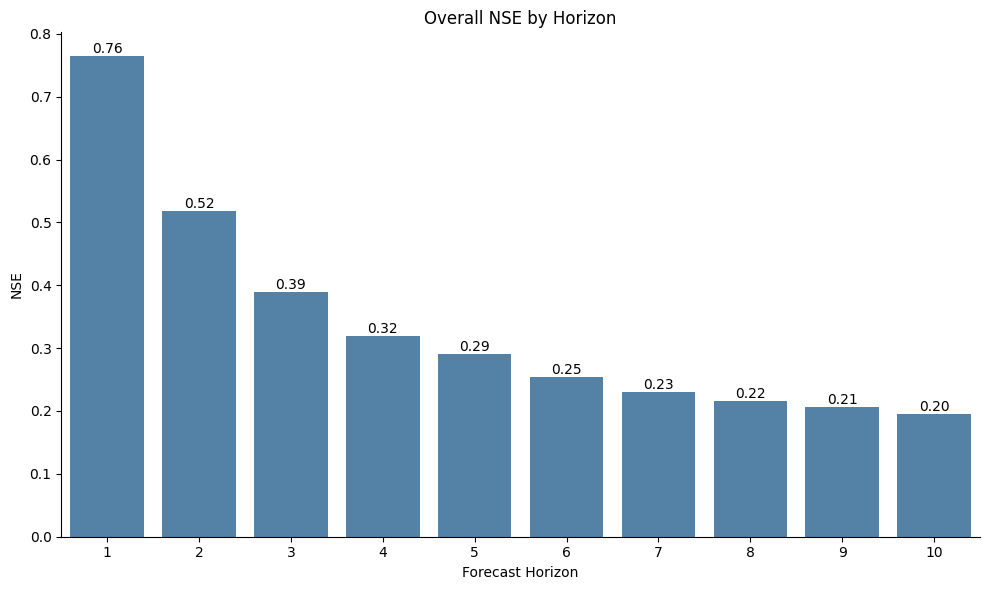

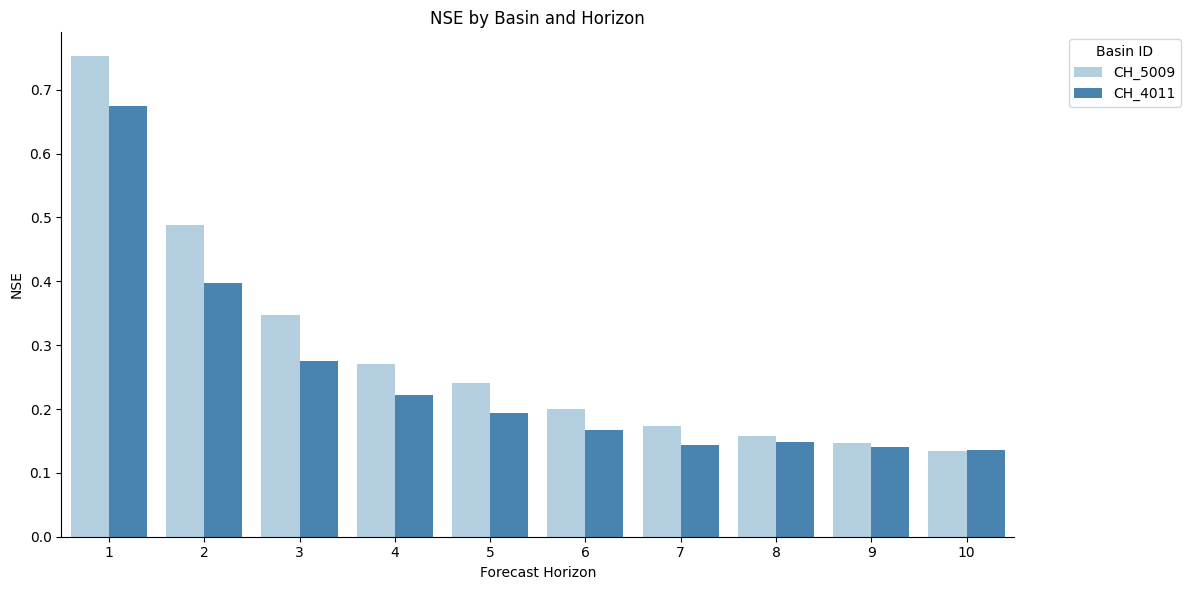

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns


def plot_metric_summary(
    summary_df: pd.DataFrame, metric: str, per_basin: bool = False, figsize=(10, 6)
):
    plt.figure(figsize=figsize)

    if per_basin:
        df_plot = summary_df[metric].unstack(level=0)

        # Sort basins based on first horizon values
        first_horizon_values = df_plot.iloc[0]
        sorted_basins = first_horizon_values.sort_values(ascending=False).index
        df_plot = df_plot[sorted_basins]

        sns.barplot(
            data=df_plot.melt(ignore_index=False).reset_index(),
            x="horizon",
            y="value",
            hue="basin_id",
            palette="Blues",
        )
        plt.title(f"{metric} by Basin and Horizon")
        plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left", title="Basin ID")

    else:
        ax = sns.barplot(x=summary_df.index, y=summary_df[metric], color="steelblue")
        plt.title(f"Overall {metric} by Horizon")

        for i, v in enumerate(summary_df[metric]):
            ax.text(i, v, f"{v:.2f}", ha="center", va="bottom")

    plt.xlabel("Forecast Horizon")
    plt.ylabel(metric)
    plt.tight_layout()
    sns.despine()
    plt.show()


# Usage example:
plot_metric_summary(overall_summary, "NSE")  # Plot overall NSE
plot_metric_summary(
    basin_summary, "NSE", per_basin=True, figsize=(12, 6)
)  # Plot per-basin NSE

In [ ]:
# trainer.test(model, data_module)
# test_results = model.test_results

In [ ]:
# # Get the results
# results_df = model.test_results["forecast_df"]
# horizon_metrics = model.test_results["horizon_metrics"]

# horizons = []
# nse_values = []
# for horizon, metrics in horizon_metrics.items():
#     horizons.append(horizon)
#     nse_values.append(metrics["NSE"])

# # Create bar plot
# plt.figure(figsize=(10, 6))
# colors = sns.color_palette("Blues", 1)
# plt.bar(horizons, nse_values, color=colors)

# # Customize plot
# plt.xlabel("Forecast Horizon (Days)")
# plt.ylabel("Nash-Sutcliffe Efficiency")
# plt.title("Forecast Skill by Prediction Horizon")
# plt.grid(True, linestyle="--", alpha=0.3)
# sns.despine()

# # Set x-axis ticks to show all horizons
# plt.xticks(horizons)

# # Add value labels on top of each bar
# for i, v in enumerate(nse_values):
#     plt.text(i + 1, v, f"{v:.2f}", ha="center", va="bottom")

# plt.tight_layout()
# plt.show()

In [ ]:
# results_df.head(10)

In [ ]:
# # Process results_df to get NSE by basin and horizon
# basin_metrics = {}
# for basin in results_df["basin_id"].unique():
#     basin_data = results_df[results_df["basin_id"] == basin]
#     nse_values = []
#     for horizon in range(1, max(basin_data["horizon"]) + 1):
#         horizon_data = basin_data[basin_data["horizon"] == horizon]
#         nse = nash_sutcliffe_efficiency(
#             horizon_data["observed"].values, horizon_data["prediction"].values
#         )
#         nse_values.append(nse)
#     basin_metrics[basin] = nse_values

# # Sort basins by NSE at horizon 1
# sorted_basins = sorted(
#     basin_metrics.keys(), key=lambda x: basin_metrics[x][0], reverse=True
# )
# basin_metrics = {basin: basin_metrics[basin] for basin in sorted_basins}

# # Plot settings
# plt.figure(figsize=(12, 6))
# bar_width = 0.8 / len(basin_metrics)

# # Create color palette of blue shades
# colors = sns.color_palette("Blues", len(basin_metrics) + 2)[2:]

# # Create bars for each basin
# for i, (basin, nse_values) in enumerate(basin_metrics.items()):
#     x = np.arange(len(nse_values)) + i * bar_width
#     plt.bar(x, nse_values, bar_width, label=f"Basin {basin}", color=colors[i])

# # Customize plot
# plt.xlabel("Forecast Horizon (Days)", fontsize=12)
# plt.ylabel("Nash-Sutcliffe Efficiency", fontsize=12)
# plt.title("Forecast Skill by Basin and Horizon", fontsize=14, pad=20)
# plt.grid(True, linestyle="--", alpha=0.3)
# plt.legend(title="Basin ID", title_fontsize=10, fontsize=10)
# sns.despine()

# # Set x-axis ticks in middle of grouped bars
# plt.xticks(
#     np.arange(len(next(iter(basin_metrics.values()))))
#     + bar_width * (len(basin_metrics) - 1) / 2,
#     np.arange(1, len(next(iter(basin_metrics.values()))) + 1),
# )

# # Remove top and right spines
# sns.despine()

# plt.tight_layout()
# plt.show()

In [ ]:
# bar_width

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns


# def plot_predictions(results_df, n_timesteps=None):
#     # Filter for horizon 1
#     horizon_1_data = results_df[results_df["horizon"] == 1]

#     if n_timesteps:
#         # Get last n_timesteps for each basin
#         horizon_1_data = (
#             horizon_1_data.groupby("basin_id").tail(n_timesteps).reset_index(drop=True)
#         )

#     n_basins = len(horizon_1_data["basin_id"].unique())
#     n_cols = 2
#     n_rows = (n_basins + 1) // 2

#     fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 5 * n_rows))
#     axes = axes.flatten()

#     # for idx, basin in enumerate(horizon_1_data["basin_id"].unique()):
#     for idx, basin in enumerate(["CH_4011"]):
#         basin_data = horizon_1_data[horizon_1_data["basin_id"] == basin]
#         ax = axes[idx]

#         nse = nash_sutcliffe_efficiency(
#             basin_data["observed"].values, basin_data["prediction"].values
#         )

#         x = np.arange(len(basin_data))
#         ax.plot(x, basin_data["observed"], label="Observed", color="#1d4ed8")
#         ax.plot(
#             x,
#             basin_data["prediction"],
#             label="Predicted",
#             color="#dc2626",
#             alpha=0.8,
#         )

#         ax.set_title(f"Basin {basin} (NSE: {nse:.3f})", fontsize=12)
#         ax.set_xlabel("Time Step", fontsize=10)
#         ax.set_ylabel("Discharge", fontsize=10)
#         ax.grid(True, linestyle="--", alpha=0.3)
#         ax.legend(fontsize=9)
#         sns.despine(ax=ax)

#     for idx in range(n_basins, len(axes)):
#         fig.delaxes(axes[idx])

#     plt.tight_layout()
#     plt.show()


# # Example usage:
# plot_predictions(results_df, n_timesteps=200) 

In [ ]:
# print("Test results available:", hasattr(model, 'test_results'))
# if hasattr(model, 'test_results'):
#     print("\nKeys in test_results:", model.test_results.keys())

In [ ]:
# def analyze_basin_data(forecast_df):
#     for basin in forecast_df['basin_id'].unique():
#         basin_data = forecast_df[forecast_df['basin_id'] == basin]
        
#         # Check for gaps
#         missing_mask = basin_data['observed'].isna() | basin_data['prediction'].isna()
#         n_missing = missing_mask.sum()
        
#         # Check for constant values
#         obs_std = basin_data['observed'].std()
        
#         print(f"\nBasin {basin}:")
#         print(f"Total samples: {len(basin_data)}")
#         print(f"Missing values: {n_missing}")
#         print(f"Observed std: {obs_std:.6f}")
#         if n_missing > 0:
#             print("Gap locations:")
#             gap_starts = basin_data[missing_mask]['horizon'].values
#             for gap in gap_starts:
#                 print(f"  Horizon: {gap}")

# analyze_basin_data(model.test_results['forecast_df'])

In [ ]:
# test_results